## Эксперимент по вливанию коллекции в тематическую модель

In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
%matplotlib inline
import os
import sys
import glob
import json
import urllib
import pymongo
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
import artm
import hierarchy_utils

In [6]:
db = pymongo.MongoClient()["datasets"]

In [7]:
prefix_to_col_map = {"pn": "postnauka", "habr": "habrahabr"}

def get_document(doc_id, with_markdown=False):
    fields = {"_id": 1, "title": 1, "modalities": 1}
    if with_markdown:
        fields["markdown"] = 1
    prefix, _ = doc_id.split("_", 1)
    col_name = prefix_to_col_map[prefix]
    return db[col_name].find_one({"_id": doc_id}, fields)

In [8]:
# Шаг 1 -- получение ранжированного списка документов для доливания

reduced_dataset = True
shuffled_dataset = False

docs_ids = list(map(lambda r: r["_id"], db["postnauka"].find({}, {"_id": 1})))

D_a = len(docs_ids)

clf_output = pd.read_csv("classifier_output.csv")
clf_output.columns = ["id", "proba"]
clf_output = clf_output.set_index("id")["proba"].sort_values(ascending=False)

if reduced_dataset:
    reduced_docs_ids = list(map(str.strip, open("reduced_habr_docs_ids.txt")))
    clf_output = clf_output.loc[reduced_docs_ids]
if shuffled_dataset:
    np.random.seed(42)
    clf_output = clf_output.sample(frac=1)

docs_ids += list(clf_output.index)

D_b = len(docs_ids) - D_a

In [9]:
D_a, D_b

(2976, 20000)

In [10]:
# Шаг 2 -- разбиение списка на батчи для итеративного доливания

# Будем пользоваться законом сложного процента: размер i-ого батча будет считаться как размер (i-1)-ого батча + p%.
# Тогда количество итераций n, необходимых для вливания коллекции размера D_b в коллекцию размера D_a, удовлетворяет:
# D_a * (1 + p)^n = D_a + D_b
# n = ln((D_a + D_b) / D_a) / ln(1 + p)

p = 0.1
batches = [docs_ids[:D_a]]
batch_pos = D_a

while batch_pos < len(docs_ids):
    new_batch_pos = int((1 + p) * batch_pos)
    batch = docs_ids[batch_pos:new_batch_pos]
    batches.append(batch)
    batch_pos = new_batch_pos

In [11]:
len(batches), sum(map(len, batches))

(23, 22976)

In [12]:
# Параметры ARTM модели

# Общий random seed
artm_seed = 42

# Веса всех модальностей
class_ids0 = {"text": 1.0, "flat_tag": 100.0, "text_habr": 1.0, "flat_tag_habr": 1.0}
class_ids1 = {"text": 1.0, "flat_tag": 1.0,   "text_habr": 1.0, "flat_tag_habr": 1.0}

In [13]:
# Параметры алгоритма CollectionMerge

modalities_to_use = {"text", "text_habr", "flat_tag", "flat_tag_habr"}
vw_path = "batch_vw.txt"
artm_cooc_path = "merged_cooc.txt"
artm_vocab_path = "merged_vocab.txt"
artm_batch_path = "merged_batches/"
tmp_artm_batch_path = "./"

cooc_window_size = 10
ppmi_func = lambda n_uv, n_u, n_v, n: max(0, np.log(n_uv * n / n_u / n_v))

In [14]:
def build_level1(topics_cnt, level0, dictionary, batch_vectorizer, scores_list):
    # Названия тем
    topic_names1 = ["topic_%d" % i for i in range(topics_cnt)]

    # Список регуляризаторов
    regularizers_list1 = []
    regularizers_list1.append(artm.DecorrelatorPhiRegularizer(name="DecorrPhiReg1",
                              topic_names=topic_names1, tau=50000))

    # Создадим ARTM модель (второй уровень)
    level1 = hierarchy_utils.ARTM_Level(level0, phi_batch_weight=10.0**3, 
                                        topic_names=topic_names1,
                                        class_ids=class_ids1,
                                        regularizers=regularizers_list1,
                                        scores=scores_list,
                                        num_document_passes=1, 
                                        seed=artm_seed)
    level1.initialize(dictionary=dictionary)

    # Обучим модель второго уровня
    # TODO: подобрать количество итераций
    level1.fit_offline(batch_vectorizer, num_collection_passes=2)

    # Итеративное разреживание детей тем 0 уровня
    threshold = 0.05
    psi1 = level1.get_psi()
    for tau in np.arange(0.1, 0.6, 0.1):
        child_topics = []
        for t in range(len(level0.topic_names)):
            child_topics.append([])
            for s, topic_name1 in enumerate(level1.topic_names):
                if psi1.values[s, t] > threshold:
                    child_topics[t].append(topic_name1)
        # Разреживание детей каждой темы 0 уровня между собой
        for i in range(len(level0.topic_names)):
            topics_list = child_topics[i]
            level1.regularizers.add(artm.SmoothSparseThetaRegularizer(
                                    name="SPThetaReg_%d" % i,
                                    topic_names=topics_list, 
                                    tau=-tau * len(topics_list) ** 3), overwrite=True)
        # Дообучим модель второго уровня
        # TODO: подобрать количество итераций
        level1.fit_offline(batch_vectorizer, num_collection_passes=1)

    coherence = level1.score_tracker["Top10Tokens"].average_coherence[-1]
    return level1, coherence

In [69]:
%%time

max_batch_size = max(map(len, batches))

vocab_set = set()
prev_phi = None

all_chars = list(map(chr, range(ord('a'), ord('z') + 1)))
artm_batch_names_iter = itertools.product(*([all_chars] * 6))
batch_names = ["".join(next(artm_batch_names_iter)) for i in range(len(batches))]

# Удалим содержимое директории с ARTM батчами
for fname in glob.glob(artm_batch_path + "/*"):
    os.remove(fname)

# Создадим файлы с ARTM vocabulary
open(artm_vocab_path, "w").close()

for batch_name, batch in zip(batch_names, batches):
    batch_vocab = []

    # Запишем документы, словарь и cooc-словарь из батча в файлы
    with open(vw_path, "w") as vw_f, open(artm_vocab_path, "a") as vocab_f:
        for doc in map(get_document, batch):
            doc_id = doc["_id"]
            modalities_str = []
            for mod_name, mod in doc["modalities"].items():
                if mod_name in modalities_to_use:
                    modalities_str.append("|%s %s" % (mod_name, " ".join(mod)))
                    for token in mod:
                        token = token.replace(" ", "_")
                        vocab_entry = (token, mod_name)
                        if vocab_entry not in vocab_set:
                            vocab_set.add(vocab_entry)
                            batch_vocab.append(vocab_entry)
            vw_f.write("%s %s\n" % (doc_id, " ".join(modalities_str)))
        for vocab_entry in batch_vocab:
            vocab_f.write("%s %s\n" % vocab_entry)

    # Создадим ARTM батч по нашему батчу
    tmp_batch_vectorizer = artm.BatchVectorizer(data_format="vowpal_wabbit", data_path=vw_path,
                                                batch_size=max_batch_size, target_folder=tmp_artm_batch_path,
                                                gather_dictionary=False)
    # Хак: переименуем ARTM батч во временное имя,
    # чтобы не мешать созданию других ARTM батчей
    os.rename("%s/aaaaaa.batch" % tmp_artm_batch_path,
              "%s/%s.batch"     % (artm_batch_path, batch_name))
    
    # Создадим ARTM dictionary
    dictionary = artm.Dictionary("dictionary")
    dictionary.gather(artm_batch_path, vocab_file_path=artm_vocab_path,
                      cooc_file_path=artm_cooc_path, symmetric_cooc_values=True)

    # Загрузим созданные на данный момент ARTM батчи
    batch_vectorizer = artm.BatchVectorizer(data_format="batches", data_path=artm_batch_path,
                                            gather_dictionary=False)

    # Метрики качества
    scores_list = []
    scores_list.append(artm.PerplexityScore(name="PerplexityScore", class_ids=["text"]))
    scores_list.append(artm.TopTokensScore(name="Top10Tokens", class_id="text", num_tokens=10,
                                           dictionary=dictionary))

    for t in range(10, 401, 10):
        # Названия тем
        norm_topic_names = ["topic_%d" % i for i in range(0, t)]
        background_names = ["background_%d" % i for i in range(0, 1)]
        topic_names0 = norm_topic_names + background_names

        # Регуляризаторы
        regularizers_list0 = []
        regularizers_list0.append(artm.DecorrelatorPhiRegularizer(name="DecorrPhiReg",
                                                                  topic_names=norm_topic_names,
                                                                  tau=100000))
        regularizers_list0.append(artm.SmoothSparseThetaRegularizer(name="SPPhiTagRegBackground",
                                                                   topic_names=background_names,
                                                                   tau=100))

        level0 = artm.ARTM(topic_names=topic_names0, class_ids=class_ids0,
                           regularizers=regularizers_list0, scores=scores_list,
                           cache_theta=False, theta_columns_naming="title",
                           seed=artm_seed)
        level0.initialize(dictionary=dictionary)
    
        # Инициализиуем матрицу Фи значениями с предыдущей итерации
        if prev_phi is not None:
            meta_info, phi_ref = level0.master.attach_model(level0.model_pwt)
            print(prev_phi.shape, phi_ref.shape)
            for i, j in itertools.product(*map(range, prev_phi.shape)):
                phi_ref[i, j] = prev_phi[i, j]

        # Обучим модель первого уровня
        # TODO: подобрать количество итераций
        level0.fit_offline(batch_vectorizer, num_collection_passes=3)
        coherence = level0.score_tracker["Top10Tokens"].average_coherence[-1]
        print("Level 0 coherence: %.6f, t=%d" % (coherence, t))

    # Сохраним матрицу Фи с текущей итерации
    prev_phi = level0.get_phi().values
    break

Level 0 coherence: 0.978299, t=10
Level 0 coherence: 0.888031, t=20
Level 0 coherence: 0.890127, t=30
Level 0 coherence: 0.898090, t=40
Level 0 coherence: 0.917293, t=50
Level 0 coherence: 0.893182, t=60
Level 0 coherence: 0.875464, t=70
Level 0 coherence: 0.859857, t=80
Level 0 coherence: 0.852484, t=90
Level 0 coherence: 0.865805, t=100
Level 0 coherence: 0.852112, t=110
Level 0 coherence: 0.845641, t=120
Level 0 coherence: 0.831554, t=130
Level 0 coherence: 0.840733, t=140
Level 0 coherence: 0.828020, t=150
Level 0 coherence: 0.815448, t=160
Level 0 coherence: 0.814038, t=170
Level 0 coherence: 0.831102, t=180
Level 0 coherence: 0.818743, t=190
Level 0 coherence: 0.810326, t=200


Exception ignored in: <generator object __iter__ at 0x7ff0c5ab30a0>
Traceback (most recent call last):
  File "/home/anton/ML-Env/.py3/lib/python3.5/site-packages/tqdm/_tqdm_notebook.py", line 194, in __iter__
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'


KeyboardInterrupt: 

In [70]:
s = """Level 0 coherence: 0.978299, t=10
Level 0 coherence: 0.888031, t=20
Level 0 coherence: 0.890127, t=30
Level 0 coherence: 0.898090, t=40
Level 0 coherence: 0.917293, t=50
Level 0 coherence: 0.893182, t=60
Level 0 coherence: 0.875464, t=70
Level 0 coherence: 0.859857, t=80
Level 0 coherence: 0.852484, t=90
Level 0 coherence: 0.865805, t=100
Level 0 coherence: 0.852112, t=110
Level 0 coherence: 0.845641, t=120
Level 0 coherence: 0.831554, t=130
Level 0 coherence: 0.840733, t=140
Level 0 coherence: 0.828020, t=150
Level 0 coherence: 0.815448, t=160
Level 0 coherence: 0.814038, t=170
Level 0 coherence: 0.831102, t=180
Level 0 coherence: 0.818743, t=190
Level 0 coherence: 0.810326, t=200"""

ys, xs = zip(*map(lambda r: tuple(map(float, r.split(": ", 1)[1].split(", t="))), s.split("\n")))

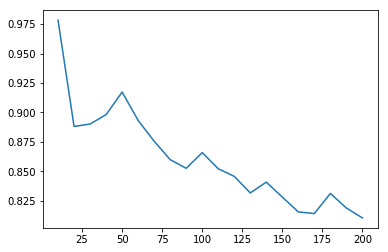

In [71]:
plt.plot(xs, ys)

```
top-10 tokens
Level 0 coherence: 0.862778, t=10
Level 0 coherence: 1.159598, t=20
Level 0 coherence: 1.267626, t=30
Level 0 coherence: 1.468547, t=40
Level 0 coherence: 1.530683, t=50
Level 0 coherence: 1.565759, t=60
Level 0 coherence: 1.668325, t=70
Level 0 coherence: 1.722331, t=80
Level 0 coherence: 1.779689, t=90
Level 0 coherence: 1.918866, t=100
Level 0 coherence: 1.924216, t=110
Level 0 coherence: 1.980874, t=120
Level 0 coherence: 2.079673, t=130
Level 0 coherence: 2.093757, t=140
Level 0 coherence: 2.173409, t=150
Level 0 coherence: 2.174175, t=160
Level 0 coherence: 2.205918, t=170
Level 0 coherence: 2.275994, t=180
Level 0 coherence: 2.277267, t=190
Level 0 coherence: 2.332946, t=200
Level 0 coherence: 2.346622, t=210
Level 0 coherence: 2.283602, t=220
Level 0 coherence: 2.324260, t=230
Level 0 coherence: 2.317958, t=240
Level 0 coherence: 2.315762, t=250
Level 0 coherence: 2.279474, t=260
Level 0 coherence: 2.309187, t=270
Level 0 coherence: 2.252727, t=280
Level 0 coherence: 2.182547, t=290
Level 0 coherence: 2.200595, t=300
Level 0 coherence: 2.178718, t=310
Level 0 coherence: 2.021726, t=320
Level 0 coherence: 2.035341, t=330
Level 0 coherence: 2.026407, t=340
Level 0 coherence: 1.923857, t=350
Level 0 coherence: 1.828151, t=360
Level 0 coherence: 1.822736, t=370
Level 0 coherence: 1.762612, t=380
Level 0 coherence: 1.778792, t=390
Level 0 coherence: 1.736851, t=400
```

```
top-20 tokens
Level 0 coherence: 0.529625, t=10
Level 0 coherence: 0.689338, t=20
Level 0 coherence: 0.799413, t=30
Level 0 coherence: 0.945375, t=40
Level 0 coherence: 1.023195, t=50
Level 0 coherence: 1.064831, t=60
Level 0 coherence: 1.133953, t=70
Level 0 coherence: 1.254620, t=80
Level 0 coherence: 1.247764, t=90
Level 0 coherence: 1.346262, t=100
```

**NB**: в конце провести эксперимент на перемешанном clf_output -- гипотеза о независимости качества от порядка вливания документов в ТМ.

---